In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import json

from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME,
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess-gpu'
PATH_PARAM = '../input/optuna-xgboost'

TEST_PATH = [
    '../input/xgboost-tuned'
]

In [2]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    feature_dic = pickle.load(file)
    
#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

In [3]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

In [4]:
sub = pd.read_csv(
    os.path.join(TEST_PATH[0], 'submission.csv')
)

sub['target_fold'] = (sub['target']>=.5).astype(int)

In [5]:
#DEFINE FOLD same as PREPROCESS
strat_fold = StratifiedKFold(n_splits = N_FOLD, random_state = RANDOM_STATE, shuffle = True)
sub[FOLD_STRAT_NAME] = -1

for i, (train_index, test_index) in enumerate(strat_fold.split(sub, sub['target_fold'])):
    sub.loc[test_index, FOLD_STRAT_NAME] = i

In [6]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [7]:
test = pd.concat([test, sub[['target', FOLD_STRAT_NAME]]], axis = 1)

In [8]:
pl_data = pd.concat([train, test], axis = 0)

In [9]:
FOLD_LIST = list(range(pl_data[FOLD_STRAT_NAME].nunique()))

gc.collect()

42

# TRAIN

In [10]:
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'seed': RANDOM_STATE,
    "learning_rate": .005,
}

#import lgb optimized parameter (file_name is wrong :()
with open(os.path.join(PATH_PARAM, 'final_xgb_param.pkl'), 'rb') as file:
    param_xgb_final = pickle.load(file)

params.update(param_xgb_final)

#pretty print
print(json.dumps(params, indent=4))


{
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "logloss",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "seed": 383920,
    "learning_rate": 0.005,
    "subsample": 0.8081548613972851,
    "colsample_bytree": 0.5093883996922348,
    "lambda": 6.593897401079495,
    "alpha": 8.220939046693244,
    "max_depth": 4,
    "gamma": 0.9917294458236702
}


In [11]:
score = 0
model_list = []

for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (pl_data[FOLD_STRAT_NAME] != fold_)
    mask_test = (pl_data[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = pl_data.loc[mask_train, FEATURE], pl_data.loc[mask_train, TARGET_COL]
    test_x, test_y = pl_data.loc[mask_test, FEATURE], pl_data.loc[mask_test, TARGET_COL]

    model = xgb.train(params = params ,
                      dtrain = xgb.DMatrix(train_x, train_y), num_boost_round = 100000,
                      evals =[(xgb.DMatrix(test_x, test_y),'valid')],
                      verbose_eval = 500, early_stopping_rounds = 500)
    
    #evaluate score and save model for importance/prediction
    score_fold = model.best_score 
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Cross Entropy: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Cross Entropy: {:.5f}\n'.format(score))

[0]	valid-logloss:0.69285
[500]	valid-logloss:0.52654
[1000]	valid-logloss:0.50141
[1500]	valid-logloss:0.49308
[2000]	valid-logloss:0.48806
[2500]	valid-logloss:0.48457
[3000]	valid-logloss:0.48197
[3500]	valid-logloss:0.47994
[4000]	valid-logloss:0.47830
[4500]	valid-logloss:0.47695
[5000]	valid-logloss:0.47581
[5500]	valid-logloss:0.47484
[6000]	valid-logloss:0.47400
[6500]	valid-logloss:0.47328
[7000]	valid-logloss:0.47264
[7500]	valid-logloss:0.47209
[8000]	valid-logloss:0.47159
[8500]	valid-logloss:0.47116
[9000]	valid-logloss:0.47078
[9500]	valid-logloss:0.47043
[10000]	valid-logloss:0.47011
[10500]	valid-logloss:0.46982
[11000]	valid-logloss:0.46957
[11500]	valid-logloss:0.46934
[12000]	valid-logloss:0.46913
[12500]	valid-logloss:0.46894
[13000]	valid-logloss:0.46876
[13500]	valid-logloss:0.46860
[14000]	valid-logloss:0.46846
[14500]	valid-logloss:0.46833
[15000]	valid-logloss:0.46821
[15500]	valid-logloss:0.46810
[16000]	valid-logloss:0.46801
[16500]	valid-logloss:0.46792
[170

# Feature importance

In [12]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    imp_dict = model.get_score(importance_type="total_gain")
    imp_temp = [imp_dict[x] if x in imp_dict.keys() else 0 for x in FEATURE]
    
    feature_importances['fold_{}'.format(fold_ + 1)] = imp_temp

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

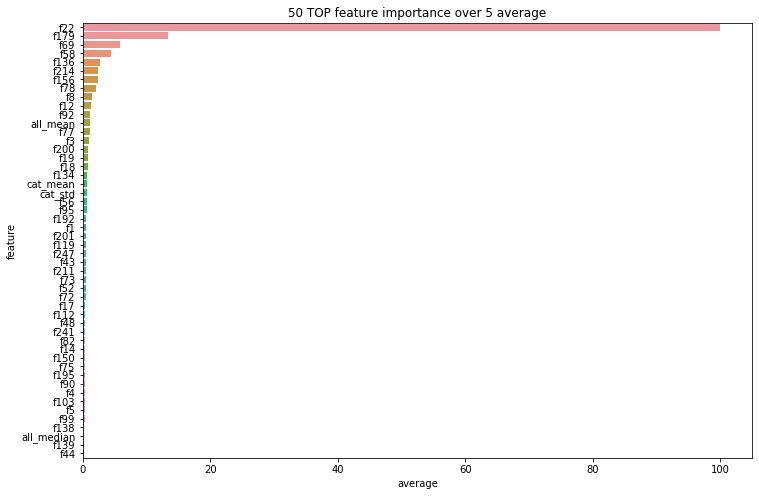

In [13]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')


# TEST Blending

In [14]:
del train
gc.collect()

36

In [15]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [16]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += model.predict(xgb.DMatrix(test))/N_FOLD

# SAVE RESULT

In [17]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)